# Part 1
# Author: Georgios Pligoropoulos < george@pligor.com >

Presentation: https://app.slidebean.com/editor/J1bdBvjhZi

In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from os import path, remove
import numpy as np
import pandas as pd
from csv import QUOTE_ALL
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
import shutil
from sklearn.metrics import r2_score
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import operator
from os.path import isfile, isdir, join
from os import getcwd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE, \
    MatrixFactorization, BiScaler
from math import floor

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
seed = 16011984
random_state = np.random.RandomState(seed=seed)
n_jobs = 1
%matplotlib inline

In [4]:
from advanced_one_hot_encoder import AdvancedOneHotEncoder

**Short sale** explained: http://www.investopedia.com/terms/r/real-estate-short-sale.asp

## Load Data

In [5]:
twin_cities_path = join(getcwd(), 'twin_cities.csv')
df = pd.read_csv(twin_cities_path, delimiter = ',', encoding='utf-8', quoting=QUOTE_ALL, index_col=0)
df.shape

(1111, 20)

In [6]:
df[:5]

,ADDRESS,CITY,STATE,ZIP,ListPrice,BEDS,BATHS,LOCATION,SQFT,LotSize,YearBuilt,ParkingSpots,HasGarage,DOM,LastSaleDate,SoldPrev,Realty,LATITUDE,LONGITUDE,ShortSale
ID,,,,,,,,,,,,,,,,,,,,
4416206,1000 Larpenteur Ave W,St. Paul,MN,55113,214000,3,2,Como,1954,6969.0,1918,2,Garage,117,6/10/2008,Y,"Edina Realty, Inc.","44,991634","-93,142616",N
4423768,1004 Charles Ave,St. Paul,MN,55104,134900,3,1,Thomas-Dale (Frogtown),1028,4356.0,1911,1,Garage,93,8/11/2010,Y,Fish MLS Realty,"44,957291","-93,142624",N
4427963,1004 Euclid St,St. Paul,MN,55106,129722,4,1,Dayton's Bluff,1420,5227.0,1900,0,No Garage,77,NaN,N,Coldwell Banker Burnet,"44,954708","-93,057976",N
4432178,1005 Saint Anthony Ave,St. Paul,MN,55104,134900,2,"1,75",Summit-University,904,8712.0,1928,3,Garage,57,NaN,N,"Real Estate Masters, Ltd.","44,952404","-93,142693",N
4440070,100X Chatsworth Pl,Shoreview,MN,55126,444900,4,"2,5",Shoreview,2014,12632.0,2014,3,Garage,8,NaN,N,Coldwell Banker Burnet,"44,944391","-93,141348",N


### DOM days on the market - the fewer the better
DOM should be considered because if there are homes standing in the market for too long might not be sell-able

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


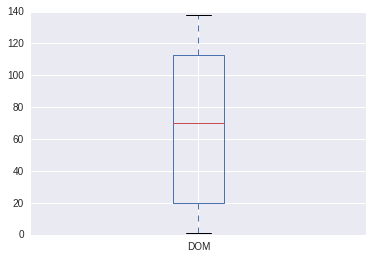

In [7]:
df['DOM'].to_frame().boxplot()
plt.show()

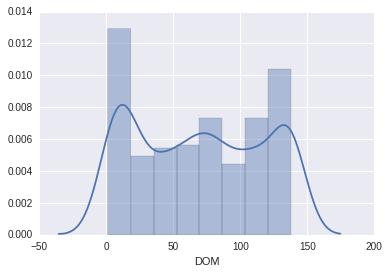

In [8]:
sns.distplot(df['DOM'])
plt.show()

## Drop redundant columns
State column does not hold any information since it is the same for all instances
Also we are dropping last sale date as we are advised to not use it but also because it contains lots of nulls

In [9]:
print "fraction of how many are empty:"
"{:.2f}%".format(100 * np.sum(df['LastSaleDate'].isnull()) / len(df))

fraction of how many are empty:


'65.98%'

In [10]:
if 'STATE' in df.columns:
    df = df.drop(labels=['STATE'], axis=1)
if 'LastSaleDate' in df.columns:
    df = df.drop(labels=['LastSaleDate'], axis=1)
df.shape

(1111, 18)

### Keep columns for Price Regression

In [11]:
#Regression Columns
#CITY, ZIP, BEDS, BATHS, SQFT, LotSize, YearBuilt, ParkingSpots, HasGarage, LATITUDE, LONGITUDE, ShortSale
XX = df[
    ['CITY', 'ZIP', 'BEDS', 'BATHS', 'SQFT', 'LotSize', 'YearBuilt', 'ParkingSpots', 'HasGarage', 'LATITUDE',
     'LONGITUDE', 'ShortSale']
]
XX.shape

(1111, 12)

In [12]:
#target: ListPrice
yy = df['ListPrice']
yy.shape

(1111,)

### Numerify data
, already numerical

In [13]:
XX['BEDS'].dtype

dtype('int64')

In [14]:
XX['SQFT'].dtype

dtype('int64')

In [15]:
XX['LotSize'].dtype

dtype('float64')

In [16]:
XX['ParkingSpots'].dtype

dtype('int64')

In [17]:
if XX['BATHS'].dtype == 'object':
    XX['BATHS'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['BATHS']]
XX['BATHS'].dtype

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


dtype('float64')

#### CITY

In [18]:
print len(XX['CITY'].unique())
XX['CITY'].unique()

6


array([u'St. Paul', u'Shoreview', u'Minneapolis', u'Woodbury',
       u'West St. Paul', u'Maplewood'], dtype=object)

In [19]:
if 'CITY' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='CITY')
XX.shape

(1111, 16)

#### ZIP

In [20]:
#comparing locations and zips lengths
print len(df['LOCATION'].unique())
print len(df['ZIP'].unique())

86
33


In [21]:
if 'ZIP' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='ZIP')
XX.shape

(1111, 47)

#### Year Built to Age

In [22]:
if 'YearBuilt' in XX.columns:
    XX['age'] = 2014 - XX['YearBuilt']
    XX.drop(labels='YearBuilt', axis=1, inplace=True)
assert 'age' in XX.columns
XX.shape

(1111, 47)

#### Has Garage to binary

In [23]:
XX['HasGarage'].unique()

array([u'Garage', u'No Garage'], dtype=object)

In [24]:
if 'Garage' in XX['HasGarage'].unique():
    XX['HasGarage'] = XX['HasGarage'] == 'Garage'
XX['HasGarage'].unique()

array([True, False], dtype=object)

#### Short Sale to binary

In [25]:
XX['ShortSale'].unique()

array([u'N', u'Y'], dtype=object)

In [26]:
if 'Y' in XX['ShortSale'].unique():
    XX['ShortSale'] = XX['ShortSale'] == 'Y'
XX['ShortSale'].unique()

array([False, True], dtype=object)

#### Latitude

In [27]:
if XX['LATITUDE'].dtype == 'object':
    XX['LATITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LATITUDE']]
XX['LATITUDE'].dtype

dtype('float64')

#### Longitude

In [28]:
if XX['LONGITUDE'].dtype == 'object':
    XX['LONGITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LONGITUDE']]
XX['LONGITUDE'].dtype

dtype('float64')

### Fill the Gaps
Rule of thumb of KNN to pick a neighborhood of 1%

In [29]:
#before
null_sum = sum(XX.isnull().sum())
null_sum

77

In [30]:
k_factor = int(floor(len(XX) * 0.01))
k_factor

11

In [31]:
nulls = XX.isnull().sum()
nulls[nulls > 0]

BATHS         1
LotSize      64
LATITUDE      6
LONGITUDE     6
dtype: int64

In [32]:
if null_sum > 0:
    XX[XX.columns] = KNN(k=k_factor).complete(XX.values)

Imputing row 1/1111 with 0 missing, elapsed time: 0.386
Imputing row 101/1111 with 1 missing, elapsed time: 0.387
Imputing row 201/1111 with 1 missing, elapsed time: 0.388
Imputing row 301/1111 with 0 missing, elapsed time: 0.389
Imputing row 401/1111 with 0 missing, elapsed time: 0.389
Imputing row 501/1111 with 0 missing, elapsed time: 0.390
Imputing row 601/1111 with 0 missing, elapsed time: 0.390
Imputing row 701/1111 with 0 missing, elapsed time: 0.391
Imputing row 801/1111 with 0 missing, elapsed time: 0.391
Imputing row 901/1111 with 0 missing, elapsed time: 0.392
Imputing row 1001/1111 with 0 missing, elapsed time: 0.392
Imputing row 1101/1111 with 0 missing, elapsed time: 0.393


In [33]:
XX.sample(random_state=random_state)

,BEDS,BATHS,SQFT,LotSize,ParkingSpots,HasGarage,LATITUDE,LONGITUDE,ShortSale,CITY_0,...,ZIP_23,ZIP_24,ZIP_25,ZIP_26,ZIP_27,ZIP_28,ZIP_29,ZIP_30,ZIP_31,age
ID,,,,,,,,,,,,,,,,,,,,,
4433532,4.0,1.5,1685.0,6534.0,2.0,1.0,45.045876,-93.289268,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0


In [34]:
sum(XX.isnull().sum())

0

#### which columns we have NOT included for training

In [35]:
print "which columns we have NOT included for training"
set(df.columns).difference(XX.columns)

which columns we have NOT included for training


{u'ADDRESS',
 u'CITY',
 u'DOM',
 u'LOCATION',
 u'ListPrice',
 u'Realty',
 u'SoldPrev',
 u'YearBuilt',
 u'ZIP'}

Let's give an explanation why according to our domain knowledge we have excluded these infomation:

- Address is the name of street, and sometimes this could be useful since houses in the same road tend to have similar prices but we have to experiment with various preprocessing steps which we cannot afford to do in the time scope of this exercise

- City has been one-hot encoded

- Days On the Market is information of how long a house is for sale. This could be an indicator of the price but because houses do not lose value proportionally to the days that they are for sale, we consider it to play a small role.

- Location is yet another categorization of the area. We are going to let the zip codes provide organizational information around the price of an area

- ListPrice is the targe

- Realty is just the name of the real estate company, no useful info in there

- Sold Previously is an indication if it is a second hand house or not but again it is not like it is a second hand car. The house still maintains its value.

- YearBuilt has been converted to Age

- ZIP has been one hot encoded

## Check DOM

In [36]:
#both are full without any null values
assert df['ListPrice'].isnull().sum() == 0 and df['DOM'].isnull().sum() == 0

In [37]:
from statsmodels.distributions.empirical_distribution import ECDF

In [38]:
sns.set(font_scale=1.5)

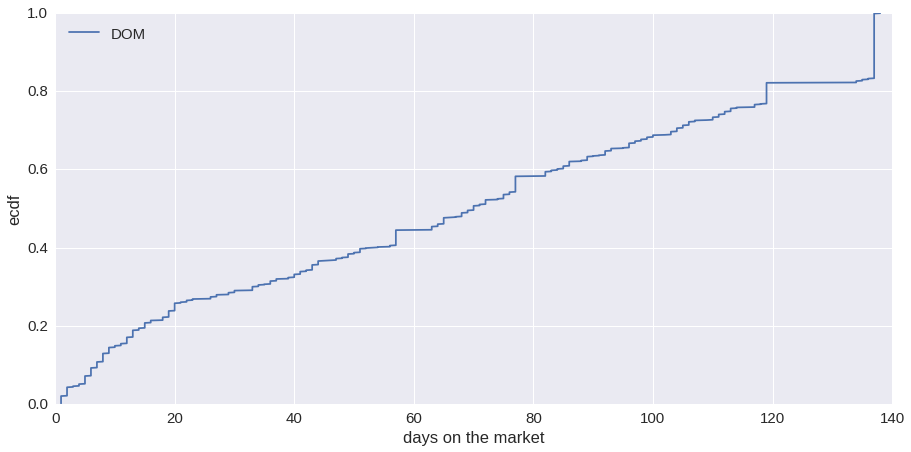

In [39]:
plt.figure(figsize=(15,7))
cdf_dom = ECDF(df['DOM'])
plt.plot(cdf_dom.x, cdf_dom.y, label='DOM')
#cdf_price = ECDF(df['ListPrice'])
#plt.plot(cdf_price.x, cdf_price.y, label='Listing Price')
plt.xlabel('days on the market')
plt.ylabel('ecdf')
plt.legend(loc='best')
plt.show()

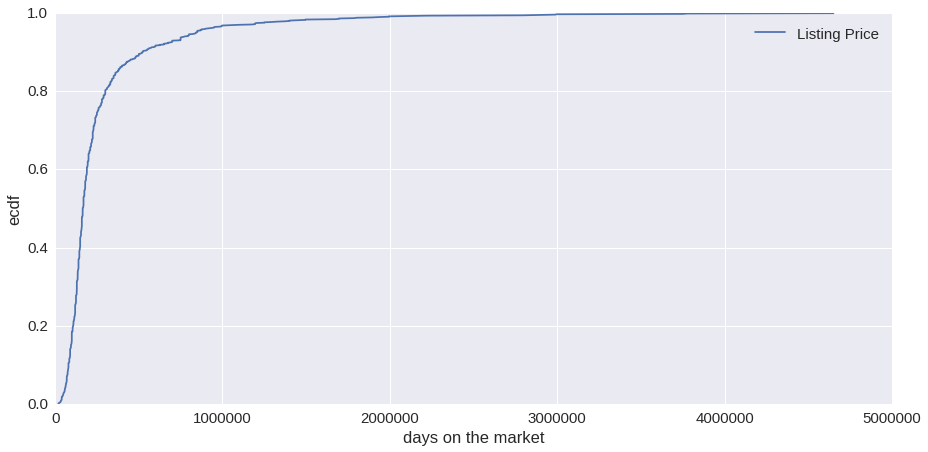

In [40]:
plt.figure(figsize=(15,7))
cdf_price = ECDF(df['ListPrice'])
plt.plot(cdf_price.x, cdf_price.y, label='Listing Price')
plt.xlabel('days on the market')
plt.ylabel('ecdf')
plt.legend(loc='best')
plt.show()

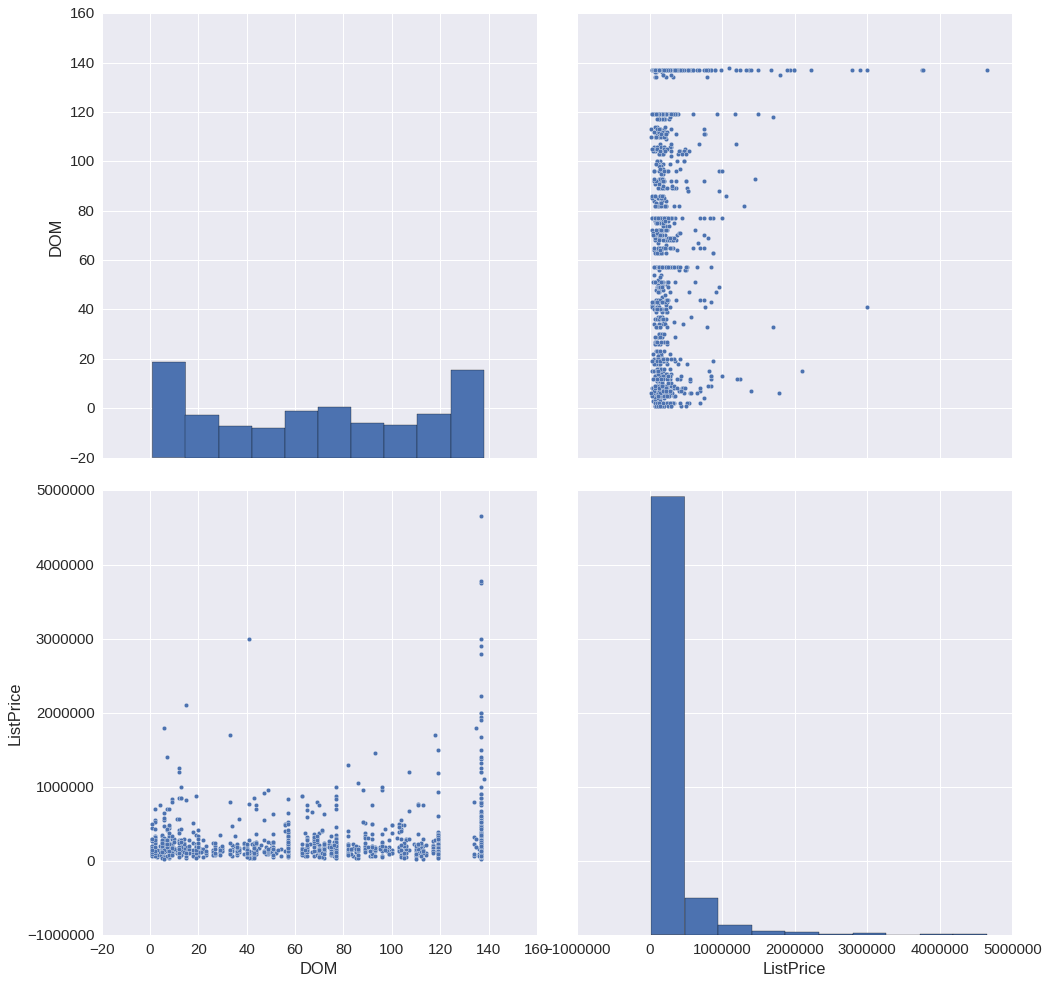

In [41]:
#plt.figure(fig)
sns.pairplot(df, vars=['DOM', 'ListPrice'], size=7)
plt.show()

In [42]:
from scipy.stats import pearsonr

In [43]:
pearsonr(df['DOM'], df['ListPrice']) #very small correlation between them

(0.1354929704802873, 5.8417648057133362e-06)

Our test statistic will be the coefficient to linear regression

Null hypothesis: We are considering that there is no relation between DOM and Listing Price and thus the coefficient for the linear regression must be near zero.

We will sample the dataset multiple times and we are going to check the probability, the p_value of having a coefficient that is at least as extreme as the one that we observed

In [44]:
observed_slope, obs_inter = np.polyfit(df['DOM'], df['ListPrice'], deg=1)
observed_slope, obs_inter

(1075.9830340660567, 196650.92763316023)

In [45]:
from bootstrap_pairs_linear_regression import draw_bs_pairs_linreg

In [46]:
%%time
slopes, intercepts = draw_bs_pairs_linreg(df['DOM'], df['ListPrice'], size=int(1e4), random_state=random_state)

CPU times: user 44.4 s, sys: 736 ms, total: 45.2 s
Wall time: 11.3 s


In [47]:
slope_std = np.std(slopes)
slope_std

300.32941093073993

In [48]:
len(slopes), len(intercepts)

(10000, 10000)

In [49]:
p_value = np.sum( np.abs(slopes) < slope_std) / len(slopes)
p_value

0.0028

So having slopes one standard deviation from zero is highly unlikely and we have to reject the hypothesis that there is no relation between DOM and listing price and that it was only by chance.

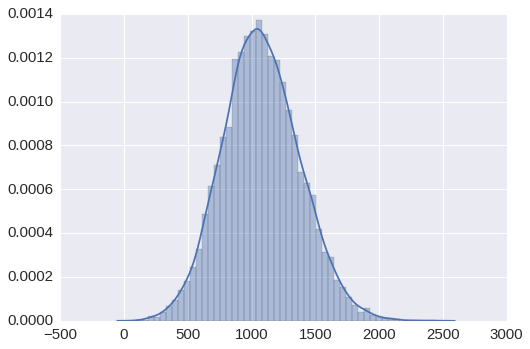

In [50]:
# Put the variance in units of square centimeters
# Make a histogram of the results
sns.distplot(slopes)
plt.show()

In [51]:
get_ci = lambda seq, ci_percentage : np.percentile(seq, [(100. - ci_percentage)/2., 50. + ci_percentage/2.])

In [52]:
get_ci(slopes, 90)

array([  603.91998573,  1588.89724536])

#### Hypothesis for no correlation
Null hypothesis: The listings have any kind of DOM value, it does not matter which
So we shuffle the DOM values alone for efficiency and we check the correlations

In [53]:
observed_pearson = pearsonr(df['DOM'], df['ListPrice'])[0] #very small correlation between them
observed_pearson

0.1354929704802873

In [54]:
%%time
scores = [pearsonr(np.random.permutation(df['DOM']), df['ListPrice'])[0] for ii in range(int(1e5))]
len(scores)

CPU times: user 15.8 s, sys: 8 ms, total: 15.8 s
Wall time: 15.8 s


So we have observed a lot of pearson scores

If we see scores which are larger than observed pearson score only a few times then this means that our observed pearson score was not by chance

In [55]:
p_value = np.sum(np.abs(scores) >= abs(observed_pearson)) / len(scores)
p_value

0.0

So we have to reject the null hypothesis that there is no correlation among the DOM values and the Listing price

# Sold Previously

In [56]:
assert df['SoldPrev'].isnull().sum() == 0, "sold previously contains empty values"

In [57]:
df['SoldPrev'].unique()

array([u'Y', u'N'], dtype=object)

In [58]:
#too many instances for swarm plot, both to tells anything useful and to be forgiving ever after
#sns.swarmplot(data=df, x='SoldPrev', y='ListPrice')

In [59]:
sold = df[df['SoldPrev'] == 'Y']['ListPrice']
new = df[df['SoldPrev'] == 'N']['ListPrice']
sold.shape, new.shape

((378,), (733,))

In [60]:
cdf_sold = ECDF(sold)
new_sold = ECDF(new)

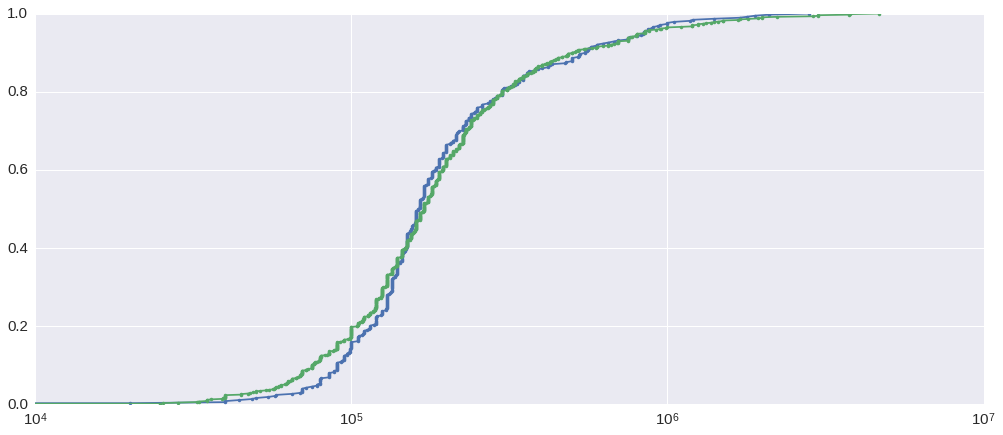

In [61]:
plt.figure(figsize=(17,7))
plt.plot(cdf_sold.x, cdf_sold.y, marker='.', label='sold')
plt.plot(new_sold.x, new_sold.y, marker='.', label='new')
plt.xscale('log')
plt.show()

They seem to originate from a similar distribution

In [62]:
sold_prev = df['SoldPrev'] == 'Y'
sold_prev[:3]

ID
4416206     True
4423768     True
4427963    False
Name: SoldPrev, dtype: bool

In [63]:
pearsonr(sold_prev, df['ListPrice'])

(-0.021516020081807526, 0.47371943561311314)

## Are the distributions similar of sold vs non sold?

In [64]:
from scikits import bootstrap

In [65]:
arr = np.array([0, 3, 11])
arr.shape

(3,)

In [66]:
arr[bootstrap.bootstrap_indexes(arr, 10)]

array([[11,  0,  3],
       [ 0,  3, 11],
       [ 0,  3,  3],
       [ 3, 11,  0],
       [11,  0,  3],
       [11, 11,  3],
       [11,  3,  0],
       [ 0,  3,  3],
       [ 0,  3,  0],
       [11,  3,  0]])

In [67]:
prices = df['ListPrice']

In [68]:
abs_diff_means = lambda aa, bb : abs(np.mean(aa) - np.mean(bb))

In [69]:
empirical_diff = abs_diff_means( prices[df['SoldPrev'] == 'Y'], prices[df['SoldPrev'] == 'N'] )
empirical_diff

16933.68924908145

Our test statistic will be the differences of means from the two.

Null Hypothesis: The instances either of sold previously, or of being new, originate from exactly the same distribution

We will mix and match considering that the prices come either from the one or from other. That if they come from the one or the other does not matter the null hypothesis says.

If we see differences that are at least as large as the empirical diff or larger only a few times then we must say that the original difference was significant

In [70]:
from permutation_replicates import draw_perm_reps, permutation_sample

In [71]:
aa = permutation_sample(np.concatenate((sold,new)), data_1_len=len(sold))
len(aa)

2

In [72]:
sold[:10]

ID
4416206    214000
4423768    134900
4416341    134900
4440221    159000
4430384     69900
4435729    149900
4421741    147500
4437401    154900
4427106     79900
4423930    364900
Name: ListPrice, dtype: int64

In [73]:
aa[0][:10]

array([ 149900,  224990,  155900,  225000,  129900,   44900, 1100000,
        350000,  182900,  224900])

In [74]:
reps = np.array(draw_perm_reps(sold, new, func=abs_diff_means, size=int(1e4), random_state=random_state))
reps.shape

(10000,)

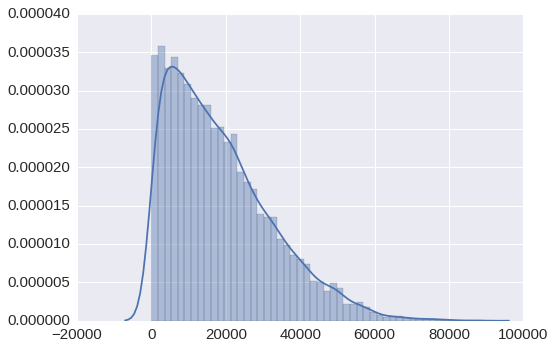

In [75]:
sns.distplot(reps)
plt.show()

In [76]:
p_value = np.sum(reps >= empirical_diff) / len(reps)
p_value

0.46760000000000002

## My Own question
We have homes that are many days on the market. Is this correlated with whether they are sold previously or not?

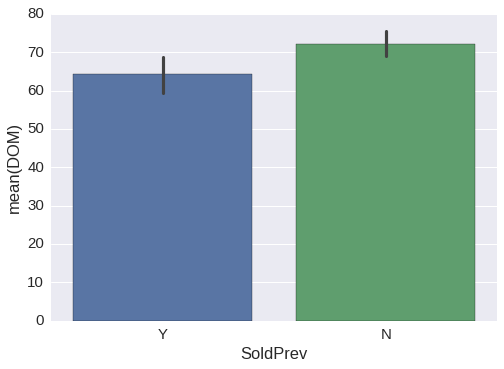

In [77]:
sns.barplot(data=df,x='SoldPrev', y='DOM')
plt.show()

You see this is a first indication. The average DOM of homes not being sold previously is larger.  
Which COULD mean that homes that have not being sold yet are not considered as easily for purchase.  
On the other hand homes that are sold previously stay on the market for shorter period on average because they are wanted, people have bought them before.

But since the buying of homes happens over years (it is not like renting) then we would be exaggerating to jump into conclusions for the factor of DOM

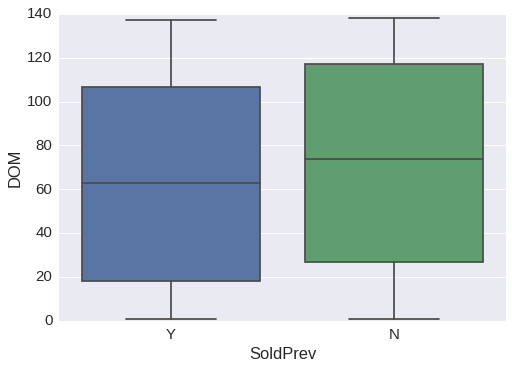

In [78]:
sns.boxplot(data=df, x='SoldPrev', y='DOM')
plt.show()

In [79]:
sold_cdf = ECDF(df[df['SoldPrev'] == 'Y']['DOM'])
new_cdf = ECDF(df[df['SoldPrev'] == 'N']['DOM'])

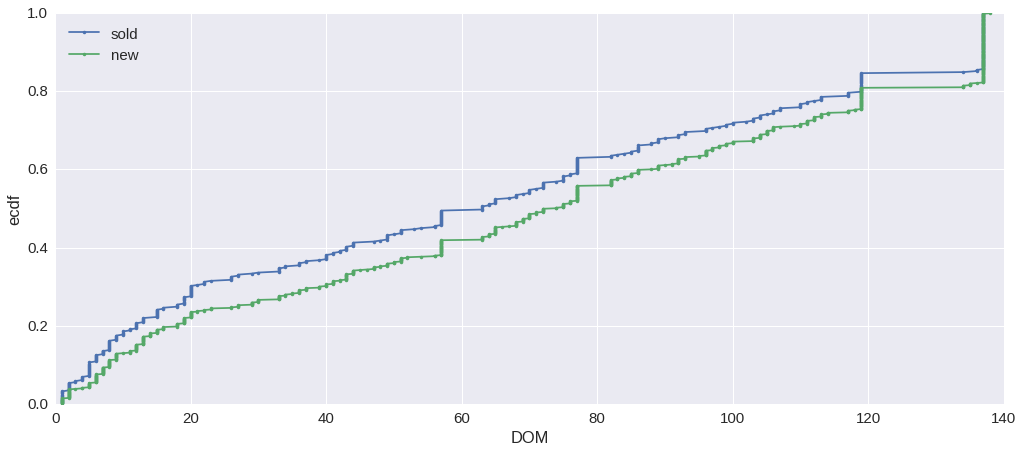

In [80]:
plt.figure(figsize=(17,7))
plt.plot(sold_cdf.x, sold_cdf.y, label='sold', marker='.')
plt.plot(new_cdf.x, new_cdf.y, label='new', marker='.')
plt.xlabel('DOM')
plt.ylabel('ecdf')
plt.legend(loc='best')
plt.show()

In [81]:
dom_sold = df[df['SoldPrev'] == 'Y']['DOM']
dom_sold.shape

(378,)

In [82]:
dom_new = df[df['SoldPrev'] == 'N']['DOM']
dom_new.shape

(733,)

In [83]:
observed_diff_mean = abs_diff_means(dom_sold, dom_new)
observed_diff_mean

7.86179143477915

So we have seen this difference in the means and we are wondering if it happened by chance

More relaxing that saying for same distributions
Our test statistic will the average value
Null Hypothesis testing: The average value of DOM is equal for the instances that were sold previously and the instances that are never sold yet

In [84]:
global_mean = np.mean(df['DOM'])
global_mean

69.47794779477948

Under the null hypothesis these two samples should have the same average value. So let's affect the average value and transform the instances

In [85]:
transf_dom_sold = dom_sold - np.mean(dom_sold) + global_mean
assert np.allclose(np.mean(transf_dom_sold), global_mean)
transf_dom_sold.shape

(378,)

In [86]:
transf_dom_new = dom_new - np.mean(dom_new) + global_mean
assert np.allclose(np.mean(transf_dom_new), global_mean)
transf_dom_new.shape

(733,)

Now we need to start sampling the values from these two collections and see what kind of difference in means we are going to observe

In [87]:
from bootstrap_replicates import draw_bootstrap_replicates

In [88]:
size = int(1e4)

In [89]:
%%time
dom_sold_means = draw_bootstrap_replicates(np.mean, size, random_state, transf_dom_sold)
dom_sold_means.shape

CPU times: user 23.3 s, sys: 0 ns, total: 23.3 s
Wall time: 23.3 s


In [90]:
%%time
dom_new_means = draw_bootstrap_replicates(np.mean, size, random_state, transf_dom_new)
dom_new_means.shape, dom_new_means[:3]

CPU times: user 41.7 s, sys: 8 ms, total: 41.7 s
Wall time: 41.7 s


In [91]:
reps_means = np.abs(dom_sold_means - dom_new_means)
reps_means.shape

(10000,)

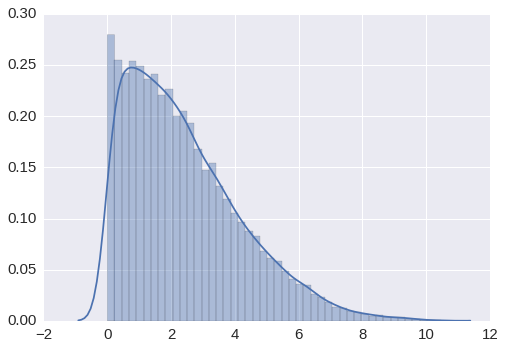

In [92]:
sns.distplot(reps_means)
plt.show()

So now we need to check the original difference in means, how many times have we observed that?

If we have observed it only a few times then we need to reject the (null)hypothesis that the means are the same

In [93]:
observed_diff_mean

7.86179143477915

In [94]:
p_value = np.sum(reps_means >= observed_diff_mean) / len(reps_means)
p_value

0.0088999999999999999

p-value is not very small but it is smaller than 0.05 or 0.01 that are two common thresholds to say that we must reject the null hypothesis indeed

The difference is averages is significant even though we cannot say how much

# Question 1
You are home developer looking to partner with the top real estate companies to acquire
and then sell a large volume of properties in the Twin Cities area (the more the better).
You do not have the resources to manage too many real estate partners and a strict
timeline to negotiate the deals.  
What realty companies would you pick as your partners? Why would you make that
choice? Demonstrate this through analysis, visual display of your results, and
description of your methodology of selection.

In [95]:
#we have to determine what success really is for a realty company to know that you need to partner with them
#which are the companies with the most houses acquired

In [96]:
#sold previously (binary)
#last sale date (do not use!) could be useful of recent sales
#listing price

#get the potential of each house
#just do a regression to get the value of a house
#then subtract the value of the actual price to have a sense of the actual potential

#sum up the potentials per realty company to see which companies has the most potential,
#just rank them from most potential to least

#Has been sold previously? Perhaps a place that has been sold means that it is attractive

In [97]:
X_train, X_test, y_train, y_test = train_test_split(XX, yy, train_size = 0.8, test_size=0.2,
                                                    random_state = random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((888, 47), (223, 47), (888,), (223,))

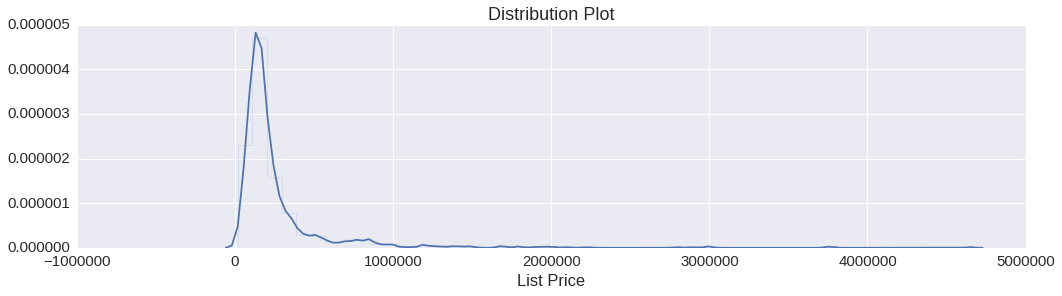

In [98]:
plt.figure(figsize=(17,4))
sns.distplot(yy, hist_kws={'histtype': 'step'})
plt.xlabel('List Price')
plt.title('Distribution Plot')
plt.show()

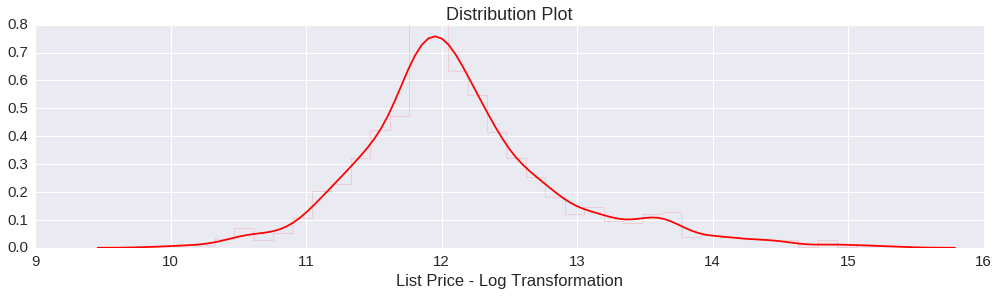

In [99]:
plt.figure(figsize=(17,4))
sns.distplot(np.log(yy), color='red', hist_kws={'histtype': 'step'})
plt.xlabel('List Price - Log Transformation')
plt.title('Distribution Plot')
plt.show()

In [100]:
def cv_for_alpha(alpha, cv=10, normalize=True):
    return np.mean(cross_val_score(estimator=Ridge(alpha=alpha, normalize=normalize), X=X_train, y=y_train, cv=cv))

In [101]:
alphas = np.logspace(start=-6, stop=0, num=100)
#alphas
alphas

array([  1.00000000e-06,   1.14975700e-06,   1.32194115e-06,
         1.51991108e-06,   1.74752840e-06,   2.00923300e-06,
         2.31012970e-06,   2.65608778e-06,   3.05385551e-06,
         3.51119173e-06,   4.03701726e-06,   4.64158883e-06,
         5.33669923e-06,   6.13590727e-06,   7.05480231e-06,
         8.11130831e-06,   9.32603347e-06,   1.07226722e-05,
         1.23284674e-05,   1.41747416e-05,   1.62975083e-05,
         1.87381742e-05,   2.15443469e-05,   2.47707636e-05,
         2.84803587e-05,   3.27454916e-05,   3.76493581e-05,
         4.32876128e-05,   4.97702356e-05,   5.72236766e-05,
         6.57933225e-05,   7.56463328e-05,   8.69749003e-05,
         1.00000000e-04,   1.14975700e-04,   1.32194115e-04,
         1.51991108e-04,   1.74752840e-04,   2.00923300e-04,
         2.31012970e-04,   2.65608778e-04,   3.05385551e-04,
         3.51119173e-04,   4.03701726e-04,   4.64158883e-04,
         5.33669923e-04,   6.13590727e-04,   7.05480231e-04,
         8.11130831e-04,

In [102]:
%%time
alpha_scores = OrderedDict()
best_alpha = None
best_cv_score = float('-inf')
for alpha in alphas:
    cur_score = cv_for_alpha(alpha=alpha)
    alpha_scores[alpha] = cur_score
    if  cur_score > best_cv_score:
        best_cv_score = cur_score
        best_alpha = alpha

CPU times: user 19 s, sys: 324 ms, total: 19.3 s
Wall time: 4.85 s


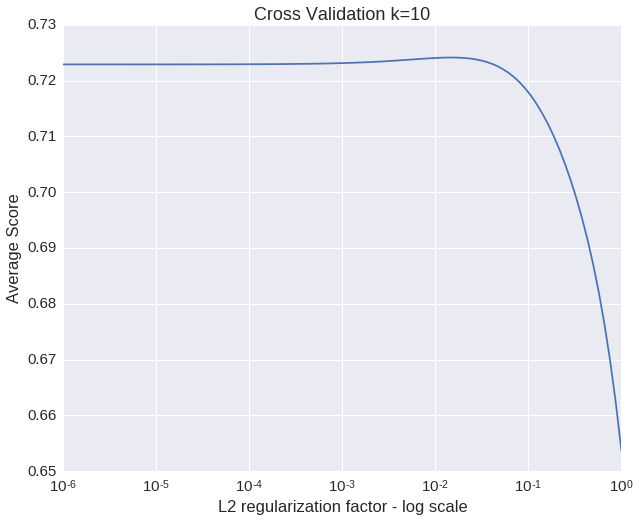

In [103]:
plt.figure(figsize=(10,8))
plt.plot(alpha_scores.keys(), alpha_scores.values())
plt.xscale('log')
plt.xlabel('L2 regularization factor - log scale')
plt.ylabel('Average Score')
plt.title('Cross Validation k=10')
plt.show()

In [104]:
best_alpha

0.015199110829529331

In [105]:
model = Ridge(alpha=best_alpha, normalize=True).fit(X_train, y_train)
model

Ridge(alpha=0.015199110829529331, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

In [106]:
model.score(X_test, y_test)

0.71965059403981824

In [107]:
model.intercept_

-80170789.964282528

In [108]:
w_df = pd.DataFrame(zip(X_test.columns, np.abs(model.coef_) ), columns=['name', 'weight'])
w_df.head(1)

,name,weight
0,BEDS,62532.990942


In [109]:
w_df.sort_values(by='weight', ascending=False)

,name,weight
6,LATITUDE,1.540826e+06
31,ZIP_17,6.424885e+05
40,ZIP_26,5.670287e+05
36,ZIP_22,2.487063e+05
44,ZIP_30,2.102041e+05
37,ZIP_23,1.898573e+05
45,ZIP_31,1.744912e+05
38,ZIP_24,1.719792e+05
21,ZIP_7,1.689421e+05
35,ZIP_21,1.653856e+05


### Conclusion
a good percentage of the variance can be explained by the linear regression

In [110]:
yy_preds = model.predict(XX)
yy_preds.shape

(1111,)

In [111]:
yy[yy==0]

Series([], Name: ListPrice, dtype: int64)

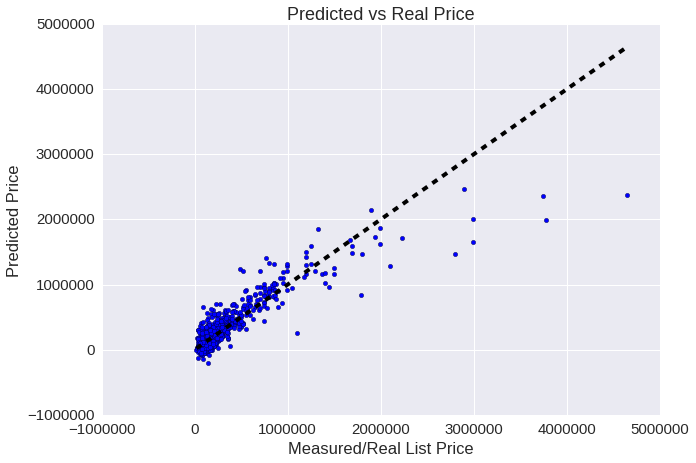

In [112]:
y_true=yy
y_pred=yy_preds
assert y_true.shape == y_pred.shape
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(y_true, y_pred)
ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
ax.set_xlabel('Measured/Real List Price')
ax.set_ylabel('Predicted Price')
ax.set_title('Predicted vs Real Price')
plt.show()

#### Calculate potential
If a home has an estimated price that is larger than its actual price then this is good. It has good potential to be sold for a higher price. And how much of a potential is the subtraction of those two.

In [113]:
potentials = yy_preds - yy
potentials.sample(random_state=random_state, n=5)

ID
4440848     -8699.198905
4432160     -6248.267382
4435179    113403.405748
4398297     76884.327797
4425359   -135059.331156
Name: ListPrice, dtype: float64

#### Potential per realty

In [114]:
rp_df = df['Realty'].to_frame().copy()
rp_df['potential'] = potentials
print rp_df.shape
rp_df.sample(n=5, random_state=random_state)

(1111, 2)


,Realty,potential
ID,,
4427697,Counselor Realty,-115566.120845
4427266,"Unity Realty, Inc.",113633.108888
4418228,RE/MAX Results,-85814.466206
4434629,RE/MAX Results,-23260.663745
4441257,"The Ewing Group, LLC",-39023.907948


In [115]:
len(rp_df['Realty'].unique())

211

In [116]:
print "Sum of potentials per Realty in descending order:"
final_df = rp_df.groupby(['Realty']).sum().sort_values(by='potential', ascending=False)
final_df.head(n=5)

Sum of potentials per Realty in descending order:


,potential
Realty,
"Edina Realty, Inc.",3.189906e+06
RE/MAX Specialists,1.612485e+06
RE/MAX Advantage Plus,1.015806e+06
RE/MAX Results,1.004010e+06
The Realty House,6.593049e+05


In [117]:
output_df = final_df.reset_index().head(n=20)
output_df

,Realty,potential
0,"Edina Realty, Inc.",3.189906e+06
1,RE/MAX Specialists,1.612485e+06
2,RE/MAX Advantage Plus,1.015806e+06
3,RE/MAX Results,1.004010e+06
4,The Realty House,6.593049e+05
5,Greenway Homes Realty,6.193820e+05
6,"The Ewing Group, LLC",6.048421e+05
7,Keller Williams Integrity,5.667468e+05
8,"Aden Realty, LLC",5.449848e+05
9,Empire Realty LLC,5.307918e+05


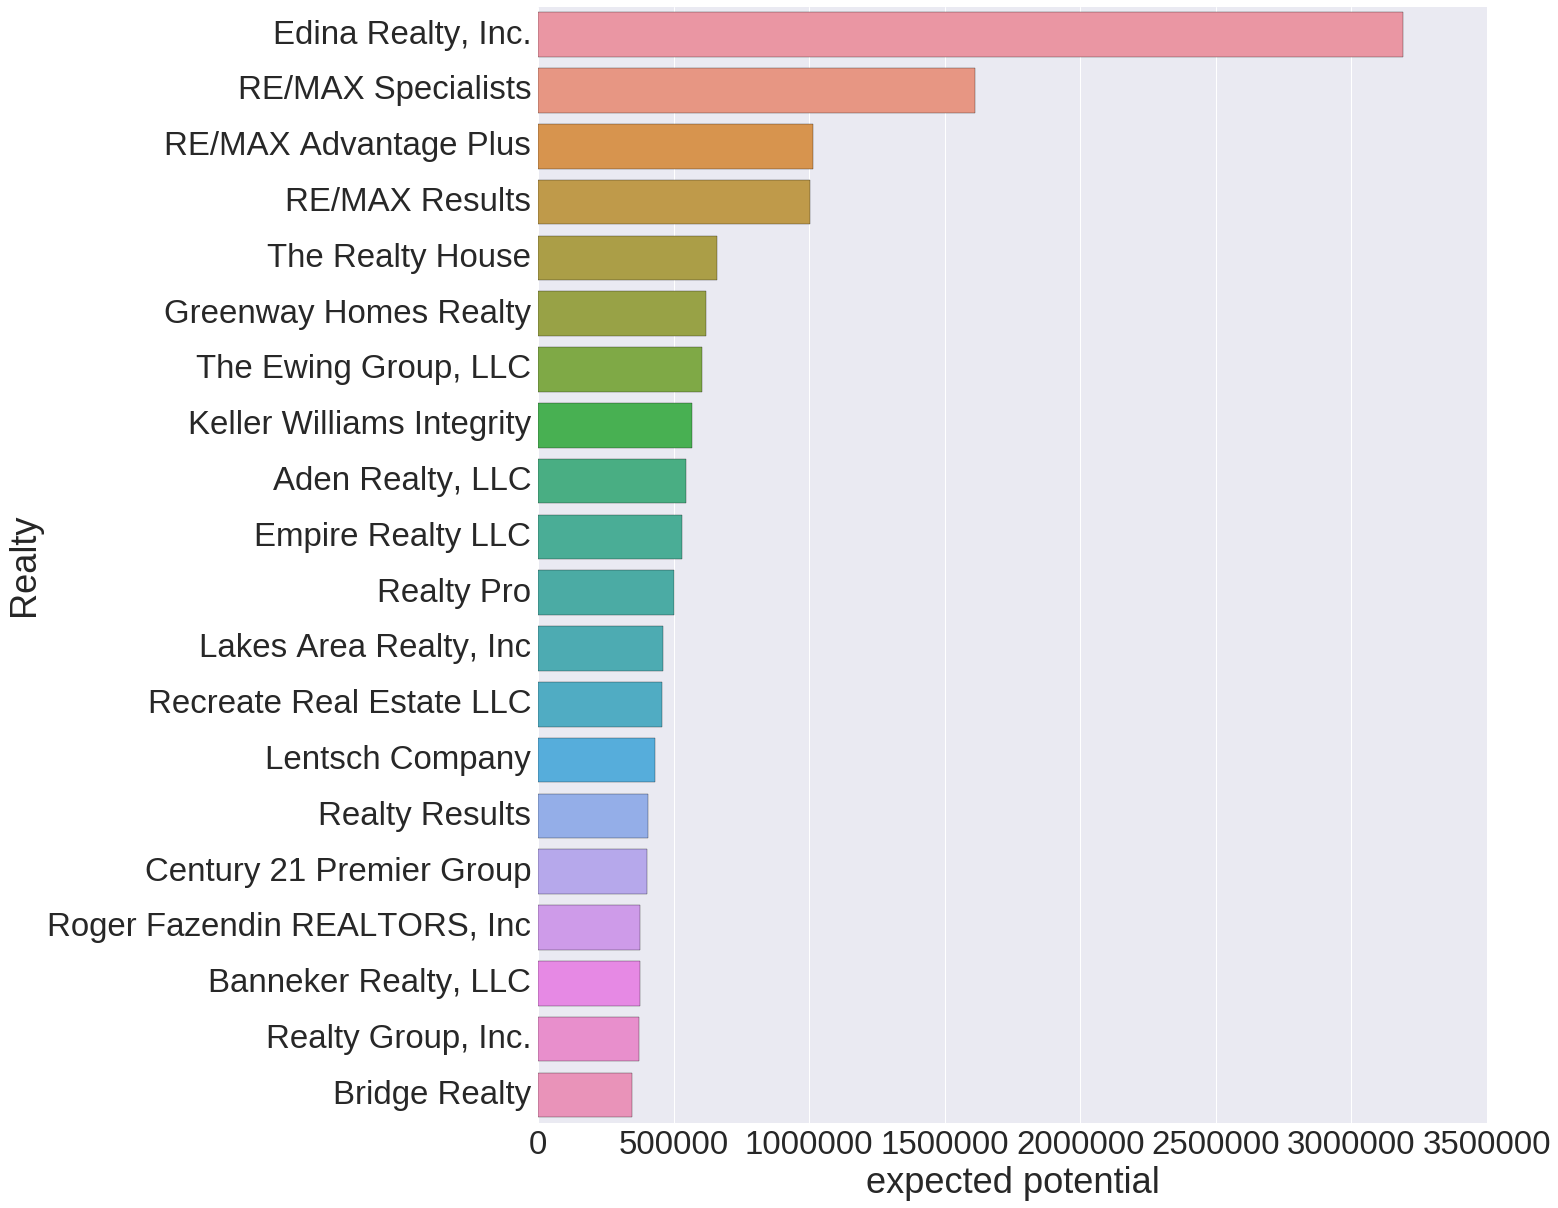

In [128]:
sns.set(font_scale=3.3)
plt.figure(figsize=(17,20))
sns.barplot(data=output_df, y='Realty', x='potential')
plt.xlabel('expected potential')
plt.show()

In [119]:
potentials = output_df['potential']

In [120]:
potential_ratio = potentials / np.sum(potentials)
potential_ratio

0     0.220418
1     0.111421
2     0.070191
3     0.069376
4     0.045557
5     0.042799
6     0.041794
7     0.039161
8     0.037658
9     0.036677
10    0.034691
11    0.031825
12    0.031564
13    0.029667
14    0.028077
15    0.027711
16    0.025893
17    0.025888
18    0.025748
19    0.023885
Name: potential, dtype: float64

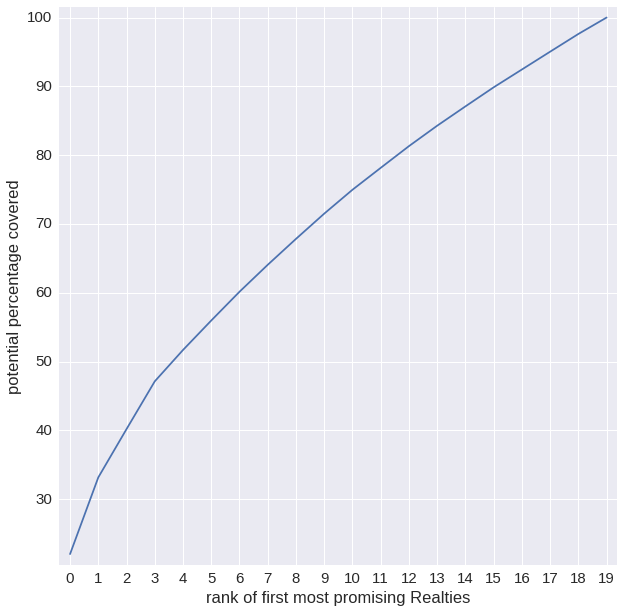

In [121]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,10))
x_axis = range(len(potential_ratio))
plt.plot(x_axis, np.cumsum(potential_ratio) * 100)
plt.ylabel('potential percentage covered')
plt.xlabel('rank of first most promising Realties')
plt.xticks(x_axis)
plt.margins(0.02)
plt.show()